In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## generate file

## functions 

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = SVC(probability=True).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "svm_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9863     ,    0.9931     
  0  ,    1.0000     ,    0.9583     ,    0.9874     ,    1.0000     ,    0.9787     
  1  ,    0.9762     ,    1.0000     ,    0.9833     ,    0.9467     ,    0.9726     
  1  ,    1.0000     ,    0.9437     ,    0.9833     ,    1.0000     ,    0.9710     
  2  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9861     ,    0.9930     
  2  ,    1.0000     ,    0.9718     ,    0.9916     ,    1.0000     ,    0.9857     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
              prec

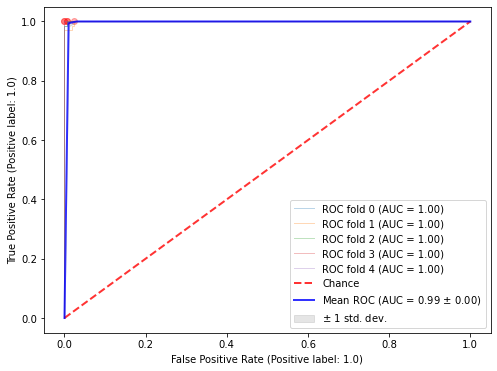

[0.9999168330006653, 0.9994131455399061, 0.9999156616344774, 1.0, 1.0]
0.9998491280350098
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.00

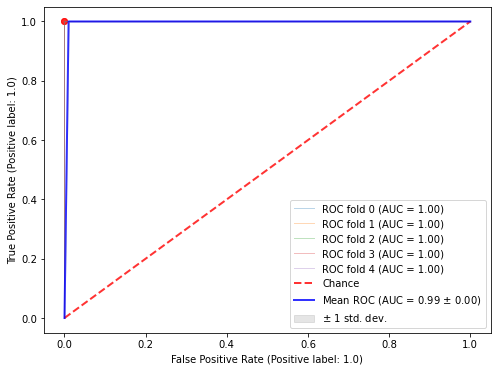

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9948     ,    0.9995     ,    1.0000     ,    0.9974     
  0  ,    0.9968     ,    0.9948     ,    0.9967     ,    0.9695     ,    0.9820     
  1  ,    0.9963     ,    0.9948     ,    0.9962     ,    0.9646     ,    0.9795     
  1  ,    0.9979     ,    0.9792     ,    0.9962     ,    0.9792     ,    0.9792     
  2  ,    0.9942     ,    0.9948     ,    0.9943     ,    0.9455     ,    0.9695     
  2  ,    0.9968     ,    0.9844     ,    0.9957     ,    0.9692     ,    0.9767     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  3  ,    0.9979     ,    0.9792     ,    0.9962     ,    0.9792     ,    0.9792     
  4  ,    0.9989     ,    0.9844     ,    0.9976     ,    0.9895     ,    0.9869     
  4  ,    0.9989     ,    0.9844     ,    0.9976     ,    0.9895     ,    

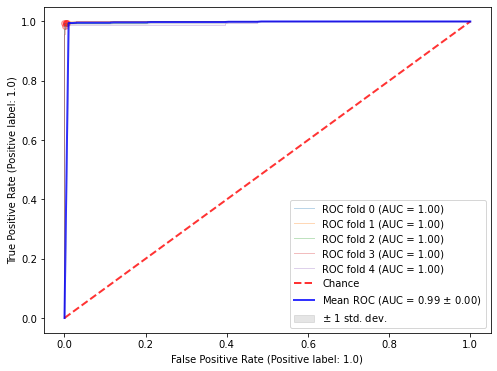

[0.9994146095938374, 0.9999015231092437, 0.9988675157563025, 0.9998030462184874, 0.9954208245798319]
0.9986815038515406
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9982     ,    1.0000     ,    0.9984     ,    0.9810     ,    0.9904     
  0  ,    0.9982     ,    1.0000     ,    0.9984     ,    0.9810     ,    0.9904     
  1  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  1  ,    0.9973     ,    1.0000     ,    0.9975     ,    0.9717     ,    0.9856     
  2  ,    0.9946     ,    0.9903     ,    0.9943     ,    0.9444     ,    0.9668     
  2  ,    0.9937     ,    0.9903     ,    0.9934     ,    0.9358     ,    0.9623     
  3  ,    0.9946     ,    1.0000     ,    0.9951     ,    0.9450     ,    0.9717     
  3  ,    0.9946     ,    0.9903     ,    0.9943     ,    0.9444     ,    0.9668     
  4  ,    0.9955     ,    1.0000     ,    0.9959     ,    0.9533     ,

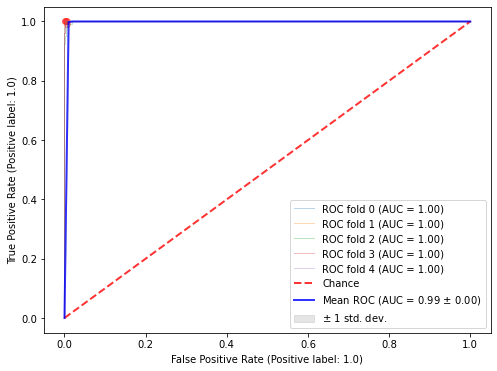

[0.9999739012423009, 0.9999913004141002, 0.999608518634513, 0.9999130041410029, 0.9999121512404245]
0.9998797751344684
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000   

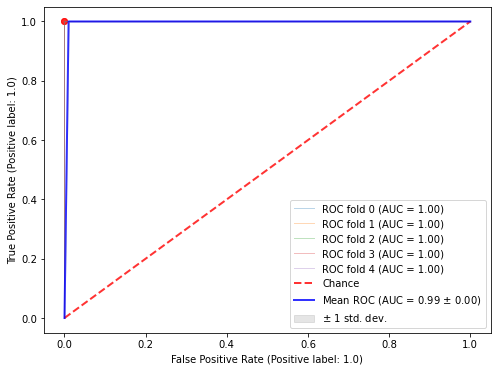

[1.0, 1.0, 1.0, 1.0, 0.9999999999999999]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9833     ,    0.9677     ,    0.9825     ,    0.7500     ,    0.8451     
  0  ,    0.9916     ,    0.9355     ,    0.9889     ,    0.8529     ,    0.8923     
  1  ,    0.9950     ,    0.9667     ,    0.9936     ,    0.9062     ,    0.9355     
  1  ,    0.9983     ,    0.9000     ,    0.9936     ,    0.9643     ,    0.9310     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  3  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  4  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,    0.9508     
  4  ,    0.9950     ,    0.9667     ,    0.9936     , 

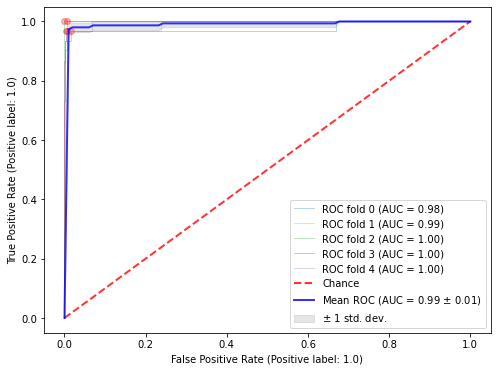

[0.9766965152659403, 0.9918060200668897, 1.0, 0.999386845039019, 0.9975473801560759]
0.9930873521055851
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9796     ,    0.9839     ,    0.9809     ,    0.9531     ,    0.9683     
  0  ,    0.9932     ,    0.9355     ,    0.9761     ,    0.9831     ,    0.9587     
  1  ,    0.9863     ,    1.0000     ,    0.9904     ,    0.9688     ,    0.9841     
  1  ,    0.9932     ,    0.9677     ,    0.9856     ,    0.9836     ,    0.9756     
  2  ,    0.9796     ,    1.0000     ,    0.9856     ,    0.9531     ,    0.9760     
  2  ,    1.0000     ,    0.9508     ,    0.9856     ,    1.0000     ,    0.9748     
  3  ,    0.9796     ,    1.0000     ,    0.9856     ,    0.9531     ,    0.9760     
  3  ,    1.0000     ,    0.9016     ,    0.9712     ,    1.0000     ,    0.9483     
  4  ,    0.9864     ,    0.9836     ,    0.9856     ,    0.9677     ,    0.9756  

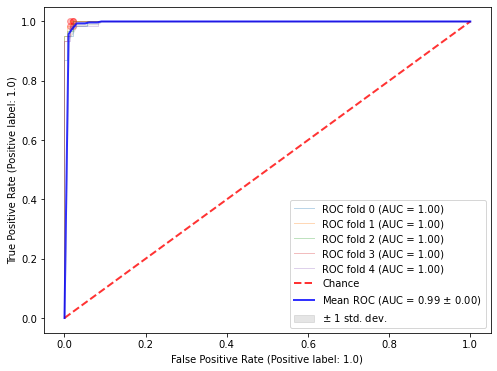

[0.9979152951503181, 0.9995581087052585, 0.9992193598750976, 0.9991078398572544, 0.9979926396788223]
0.9987586486533502
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

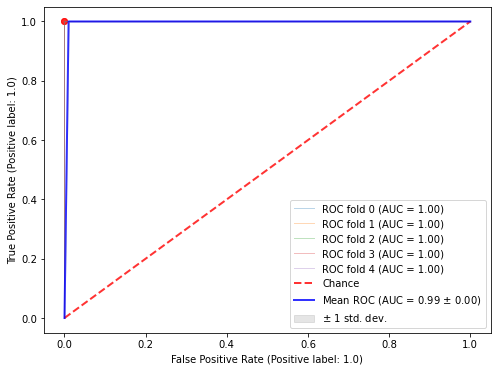

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9630     ,    0.9811     
  0  ,    1.0000     ,    0.9615     ,    0.9982     ,    1.0000     ,    0.9804     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9600     ,    0.9982     ,    1.0000     ,    0.9796     
  3  ,    1.0000     ,    0.9200     ,    0.9964     ,    1.0000     ,    0.9583     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

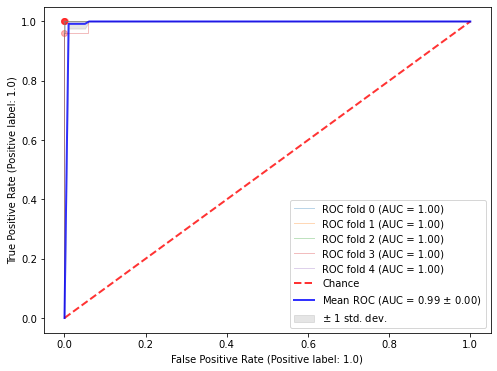

[0.9999264597734961, 1.0, 1.0, 0.9977099236641223, 1.0]
0.9995272766875237
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  0  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9946     ,    1.0000     ,    0.9950     ,    0.9375     ,    0.9677     
  2  ,    1.0000     ,    0.9333     ,    0.9950     ,    1.0000     ,    0.9655     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,   

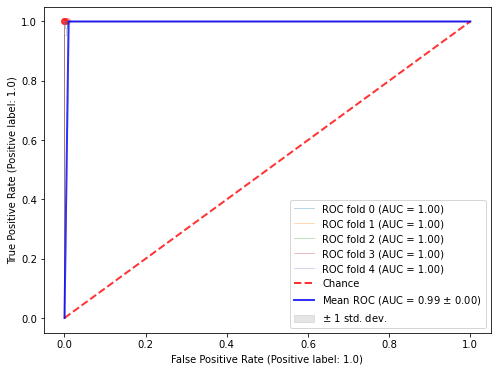

[0.9999599599599599, 1.0, 0.9997994384275973, 1.0, 1.0]
0.9999518796775113
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  2  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  2  ,    0.9985     ,    0.9821     ,    0.9972     ,    0.9821     ,    0.9821     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  4  ,    1.0000     ,   

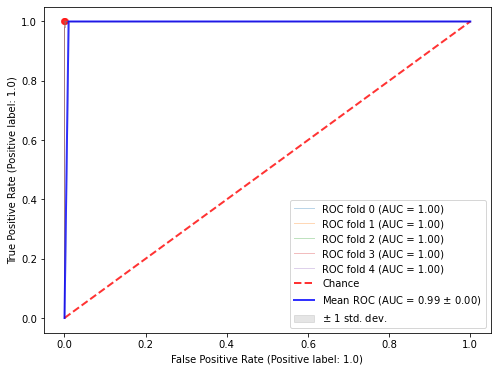

[1.0, 1.0, 0.999972442680776, 1.0, 0.999972442680776]
0.9999889770723105
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9766     ,    1.0000     ,    0.9788     ,    0.8182     ,    0.9000     
  0  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  1  ,    0.9708     ,    1.0000     ,    0.9735     ,    0.7826     ,    0.8780     
  1  ,    0.9795     ,    0.9722     ,    0.9788     ,    0.8333     ,    0.8974     
  2  ,    0.9854     ,    1.0000     ,    0.9868     ,    0.8780     ,    0.9351     
  2  ,    0.9971     ,    0.8611     ,    0.9841     ,    0.9688     ,    0.9118     
  3  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  3  ,    0.9795     ,    0.9722     ,    0.9788     ,    0.8333     ,    0.8974     
  4  ,    0.9942     ,    0.8611     ,    0.9815     ,    0.9394     ,    0.8986     
  4  ,    0.9942     ,    0

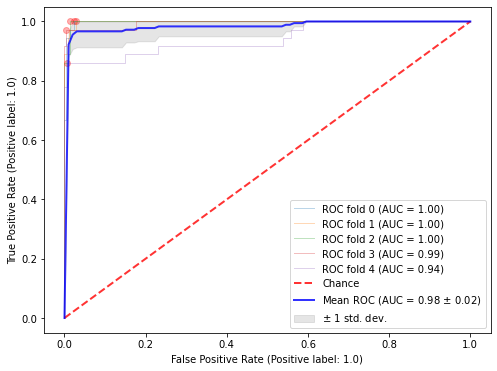

[0.9981319038336582, 0.9984567901234569, 0.9981319038336582, 0.9949642625081221, 0.9421702404158545]
0.98637102014295


In [3]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="dect")
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.7051     ,    0.6538     ,    0.7026     ,    0.1012     ,    0.1753     
  0  ,    0.9727     ,    0.2308     ,    0.9368     ,    0.3000     ,    0.2609     
  1  ,    0.6504     ,    0.8077     ,    0.6580     ,    0.1050     ,    0.1858     
  1  ,    0.9609     ,    0.1923     ,    0.9238     ,    0.2000     ,    0.1961     
  2  ,    0.5996     ,    0.8077     ,    0.6097     ,    0.0929     ,    0.1667     
  2  ,    0.9414     ,    0.3077     ,    0.9108     ,    0.2105     ,    0.2500     
  3  ,    0.5742     ,    0.8000     ,    0.5847     ,    0.0840     ,    0.1521     
  3  ,    0.9648     ,    0.1600     ,    0.9274     ,    0.1818     ,    0.1702     
  4  ,    0.6562     ,    0.8000     ,    0.6629     ,    0.1020     ,    0.1810     
  4  ,    0.9570     ,    0.2800     ,    0.9255     ,    0.2414     ,    0.2593     
              prec

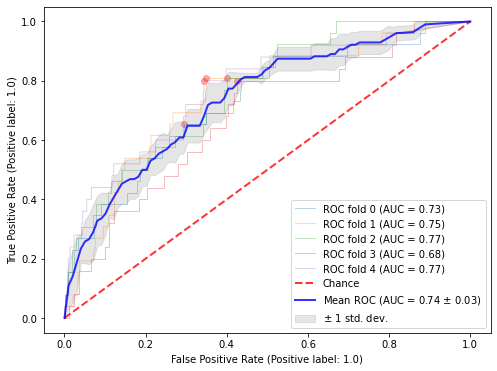

[0.7327223557692308, 0.7481971153846153, 0.7660006009615384, 0.67921875, 0.772265625]
0.739680889423077
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8390     ,    0.8864     ,    0.8426     ,    0.3120     ,    0.4615     
  0  ,    0.9513     ,    0.6364     ,    0.9273     ,    0.5185     ,    0.5714     
  1  ,    0.8837     ,    0.8222     ,    0.8789     ,    0.3737     ,    0.5139     
  1  ,    0.9343     ,    0.6444     ,    0.9118     ,    0.4531     ,    0.5321     
  2  ,    0.8143     ,    0.9111     ,    0.8218     ,    0.2929     ,    0.4432     
  2  ,    0.9343     ,    0.6222     ,    0.9100     ,    0.4444     ,    0.5185     
  3  ,    0.8612     ,    0.8889     ,    0.8633     ,    0.3509     ,    0.5031     
  3  ,    0.9418     ,    0.6000     ,    0.9152     ,    0.4655     ,    0.5243     
  4  ,    0.8649     ,    0.9111     ,    0.8685     ,    0.3628     ,    0.5190     


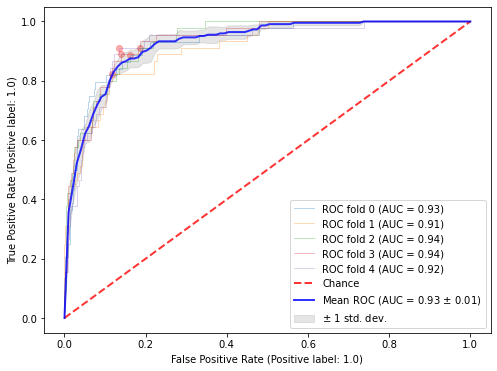

[0.9287538304392238, 0.9107775693141547, 0.9375026057952888, 0.9353762768396916, 0.9226599958307274]
0.9270140556438173
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9395     ,    0.8961     ,    0.9374     ,    0.4259     ,    0.5774     
  0  ,    0.9863     ,    0.7792     ,    0.9764     ,    0.7407     ,    0.7595     
  1  ,    0.9583     ,    0.9351     ,    0.9572     ,    0.5294     ,    0.6761     
  1  ,    0.9896     ,    0.8312     ,    0.9820     ,    0.8000     ,    0.8153     
  2  ,    0.8854     ,    0.8961     ,    0.8859     ,    0.2816     ,    0.4286     
  2  ,    0.9889     ,    0.7273     ,    0.9764     ,    0.7671     ,    0.7467     
  3  ,    0.9427     ,    0.7792     ,    0.9349     ,    0.4054     ,    0.5333     
  3  ,    0.9889     ,    0.6364     ,    0.9721     ,    0.7424     ,    0.6853     
  4  ,    0.8991     ,    0.9474     ,    0.9014     ,    0.3172     ,

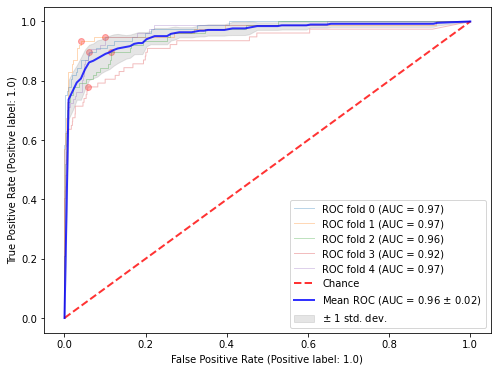

[0.9746516504329004, 0.9698491612554113, 0.9572426271645021, 0.9217397186147187, 0.9702662417763158]
0.9587498798487697
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8240     ,    0.8942     ,    0.8316     ,    0.3811     ,    0.5345     
  0  ,    0.8590     ,    0.8269     ,    0.8555     ,    0.4155     ,    0.5531     
  1  ,    0.7552     ,    0.9423     ,    0.7755     ,    0.3182     ,    0.4757     
  1  ,    0.8508     ,    0.7885     ,    0.8441     ,    0.3905     ,    0.5223     
  2  ,    0.7529     ,    0.9135     ,    0.7703     ,    0.3094     ,    0.4623     
  2  ,    0.8706     ,    0.7692     ,    0.8597     ,    0.4188     ,    0.5424     
  3  ,    0.8588     ,    0.7981     ,    0.8522     ,    0.4069     ,    0.5390     
  3  ,    0.8716     ,    0.7692     ,    0.8606     ,    0.4211     ,    0.5442     
  4  ,    0.7246     ,    0.9712     ,    0.7513     ,    0.2997     ,

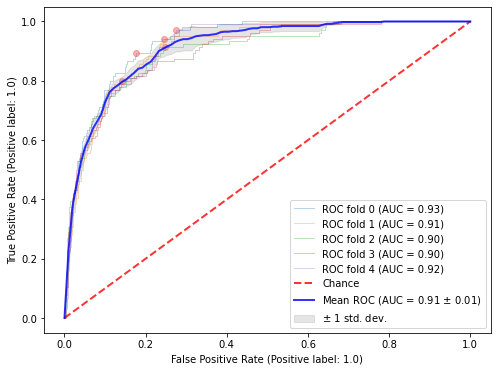

[0.9291509772279003, 0.9123968979738211, 0.9009324009324009, 0.9008392424378423, 0.9164011309577238]
0.9119441299059377
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9500     ,    0.9375     ,    0.9492     ,    0.5556     ,    0.6977     
  0  ,    0.9833     ,    0.7188     ,    0.9668     ,    0.7419     ,    0.7302     
  1  ,    0.9250     ,    0.9375     ,    0.9258     ,    0.4545     ,    0.6122     
  1  ,    0.9979     ,    0.7500     ,    0.9824     ,    0.9600     ,    0.8421     
  2  ,    0.9688     ,    0.9062     ,    0.9648     ,    0.6591     ,    0.7632     
  2  ,    0.9812     ,    0.7812     ,    0.9688     ,    0.7353     ,    0.7576     
  3  ,    0.9917     ,    1.0000     ,    0.9922     ,    0.8889     ,    0.9412     
  3  ,    0.9917     ,    1.0000     ,    0.9922     ,    0.8889     ,    0.9412     
  4  ,    0.9688     ,    1.0000     ,    0.9707     ,    0.6809     ,

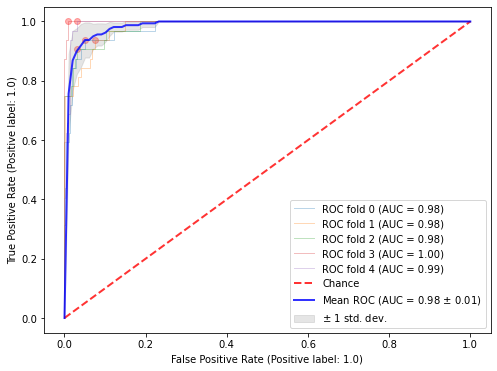

[0.9805338541666667, 0.9820963541666666, 0.984375, 0.99921875, 0.9942057291666667]
0.9880859375
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  0  ,    0.7455     ,    1.0000     ,    0.8133     ,    0.5882     ,    0.7407     
  1  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  1  ,    0.8000     ,    1.0000     ,    0.8533     ,    0.6452     ,    0.7843     
  2  ,    0.9273     ,    0.9500     ,    0.9333     ,    0.8261     ,    0.8837     
  2  ,    0.7818     ,    0.9500     ,    0.8267     ,    0.6129     ,    0.7451     
  3  ,    0.9636     ,    0.9000     ,    0.9467     ,    0.9000     ,    0.9000     
  3  ,    0.8364     ,    0.9500     ,    0.8667     ,    0.6786     ,    0.7917     
  4  ,    0.9818     ,    0.8947     ,    0.9595     ,    0.9444     ,    0.9189     
  4 

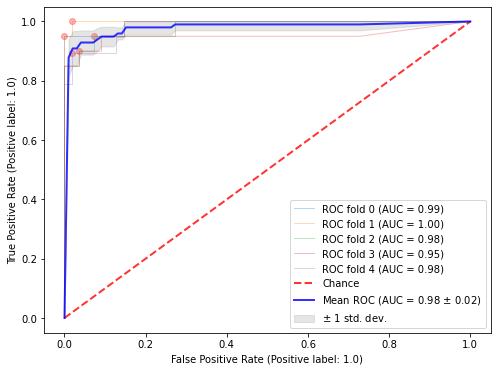

[0.9927272727272727, 0.999090909090909, 0.980909090909091, 0.9504545454545453, 0.9837320574162679]
0.9813827751196171
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9787     ,    0.8947     ,    0.9545     ,    0.9444     ,    0.9189     
  0  ,    1.0000     ,    0.7895     ,    0.9394     ,    1.0000     ,    0.8824     
  1  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  1  ,    1.0000     ,    0.8500     ,    0.9545     ,    1.0000     ,    0.9189     
  2  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  2  ,    1.0000     ,    0.8500     ,    0.9545     ,    1.0000     ,    0.9189     
  3  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  3  ,    1.0000     ,    0.8000     ,    0.9394     ,    1.0000     ,    0.8889     
  4  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000    

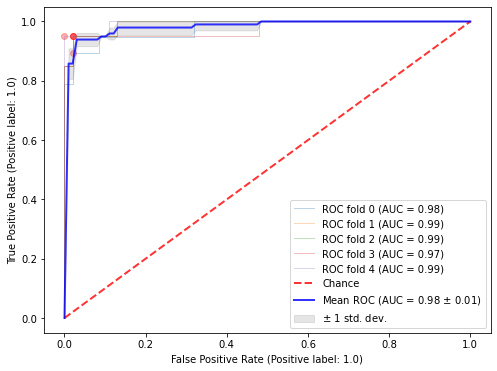

[0.9764837625979843, 0.9913043478260869, 0.9913043478260869, 0.9739130434782608, 0.9945652173913043]
0.9855141438239448


In [4]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))